In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# Hermes IO

In [2]:
cs = dict()

In [3]:
   
db = CaseDB()
toload = [
    dict(name="afnE_base", id = "d24bd-cond0.25_frec0.48"),
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True)

- Reading case d24bd-cond0.25_frec0.48
-----------------------
- Looking for squash file
- Squash file found. squash date 10/16/2023, 10:34:08, dmp file date 10/15/2023, 23:08:48



In [4]:
plt.close("all")
%matplotlib inline

## Read Hermes data

In [5]:
hr = dict()
for name in cs.keys(): 
    print(name)
    hr[name] = Hermesdata()
    hr[name].read_case(cs[name].ds.isel(t=-1, x = slice(2,-2)))
    
    if "afnE" in  name:
        new_afn = True
        print(f"Loading {name} with new AFN")
    else:
        new_afn = False
        print(f"Loading {name} with old AFN")
    
    ds = cs[name].ds
    ds = calculate_radial_fluxes(ds, new_afn = new_afn)
    ds = calculate_target_fluxes(ds)
    ds = reverse_pfr_fluxes(ds)

afnE_base
Loading afnE_base with new AFN
Calculating target recycling:
inner_lower
outer_lower
inner_upper
outer_upper


# Read SOLEDGE CSV data

In [6]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

## Read SOLPS

In [8]:
solpscases = {
    "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0"),
    "16x_mc" : os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.xxx.BCCON=16.core_extent.MC.histories.x16-ish.NOT.converged"),
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

# Target flux comparison

In [27]:
slc = SOLEDGEcase(soledgecases["tightwall_2e19"])

wfluxes = slc.get_wall_fluxes(split=True ,verbose = False)

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


get_wall_triangle
get_wall_triangles
get_wall_triangles.2: Completed
get_wall_triangle: Completed


In [32]:
df = pd.DataFrame()
wfluxes_integral = pd.DataFrame()

params = [x for x in wfluxes["inner_lower_target"].columns if x not in ["R", "Z", 'iTri', 'iSide', 'iProp', 'dlSurf', 'dlWall', 'Area']]

for region in wfluxes.keys():
    for param in params:
        wfluxes_integral.loc[region, param] = (wfluxes[region][param] * wfluxes[region]["Area"]).sum()
wfluxes_regions = wfluxes_integral.transpose()

,inner_lower_target,lower_pfr,outer_lower_target,outer_wall,outer_upper_target,upper_pfr,inner_upper_target,inner_wall
F_Ion_Incident,5.184224e+21,0.000000e+00,1.961381e+22,0.000000e+00,1.888751e+22,1.304832e+20,5.041735e+21,0.000000e+00
F_Atom_Emitted_from_Ion,3.068479e+21,0.000000e+00,1.176788e+22,0.000000e+00,1.127454e+22,8.758513e+19,2.990428e+21,0.000000e+00
F_Atom_Incident,1.433211e+21,7.146816e+21,7.839288e+21,1.845098e+22,5.894557e+21,7.015190e+21,1.393611e+21,9.785157e+20
F_Mol_Incident,2.347242e+19,2.284701e+20,4.134471e+20,9.846037e+20,2.057956e+20,2.280672e+20,2.224302e+19,1.825320e+19
F_Mol_Emitted_from_Ion,1.057872e+21,0.000000e+00,3.922970e+21,0.000000e+00,3.806484e+21,2.144904e+19,1.025654e+21,0.000000e+00
F_Atom_Emitted_from_Atom,1.081636e+21,5.555425e+21,6.039355e+21,1.371612e+22,4.587803e+21,5.477885e+21,1.048839e+21,7.058009e+20
F_Mol_Emitted_from_Atom,1.757872e+20,7.956956e+20,8.999666e+20,1.777601e+21,6.533773e+20,7.686521e+20,1.723859e+20,1.363574e+20
E_incident_Electron,5.921858e+04,0.000000e+00,2.189454e+05,0.000000e+00,2.177539e+05,2.344546e+02,5.801225e+04,0.000000e+00
E_incident_Ions,1.097904e+05,0.000000e+00,3.666358e+05,0.000000e+00,3.825433e+05,1.283253e+03,1.043603e+05,0.000000e+00
E_Total,1.445655e+05,5.038402e+04,4.879132e+05,2.320565e+05,4.938351e+05,5.228972e+04,1.394849e+05,3.856664e+04


## Format SOLEDGE table

In [79]:
df = pd.DataFrame(wfluxes_regions["outer_lower_target"])
df.columns = ["SOLEDGE"]
df[df.index.str.contains("E_")] *= 1e-6                # Energy fluxes in MW
df[df.index.str.contains("F_")] *= constants("q_e")    # Particle fluxes in A

def styler(s):
        if abs(s) < 0.001 or pd.isna(s):
            c =  "color: lightgrey"
        else:
            c =  "color: black"

        return c
    

## Add Hermes-3 numbers

### Calculate incident neutral flux

In [80]:
ds = cs["afnE_base"].ds.isel(t=-1)

target = ds.hermesm.select_region("outer_lower_target")
guard = ds.hermesm.select_region("outer_lower_target_inner_guards")

def get_val(param):
    return (target[param].values + guard[param].values)/2

Nn = get_val("Nd")
Tn = get_val("Td")
atom_pflux = Nn * 0.25 * np.sqrt( (8 * Tn * constants("q_e")) / (np.pi * constants("mass_p")*2))
atom_pflux = atom_pflux.sum()

In [62]:
Nn

7.516477276917094e+20

In [85]:
df.loc["F_Ion_Incident", "Hermes-3"] = ds["pf_outer_lower_target_d+"].sum().values * constants("q_e") * -1
df.loc["F_Atom_Emitted_from_Ion", "Hermes-3"] = (target["Sd_target_recycle"]*target["dv"]).sum().values* constants("q_e") 
df.loc["F_Mol_Emitted_from_Ion", "Hermes-3"] = 0
# df.loc["F_Atom_Incident", "Hermes-3"] = atom_pflux * constants("q_e") * -1

df.loc["E_incident_Electron", "Hermes-3"] = ds["hf_outer_lower_target_e"].sum().values * 1e-6 * -1
df.loc["E_incident_Ions", "Hermes-3"] = ds["hf_outer_lower_target_d+"].sum().values * 1e-6 * -1
df.loc["E_incident_Atoms", "Hermes-3"] = (target["Ed_target_refl"]*target["dv"]).sum().values * 1e-6 * -1

df.loc["Implied recycling fraction", :] = (df.loc["F_Atom_Emitted_from_Ion", :] + df.loc["F_Mol_Emitted_from_Ion", :])/ df.loc["F_Ion_Incident", :]

display(df.style.format("{:.3f}").applymap(styler))

,SOLEDGE,Hermes-3
F_Ion_Incident,3142.480,3631.782
F_Atom_Emitted_from_Ion,1885.422,3619.669
F_Atom_Incident,1255.992,nan
F_Mol_Incident,66.242,nan
F_Mol_Emitted_from_Ion,628.529,0.000
F_Atom_Emitted_from_Atom,967.611,nan
F_Mol_Emitted_from_Atom,144.191,nan
E_incident_Electron,0.219,0.254
E_incident_Ions,0.367,0.411
E_Total,0.488,nan


# Poloidal flux comparison

## SOLEDGE2D    

In [86]:
sl["tightwall_2e19"].regions["outer_fieldline"].keys()

Index(['Ne', 'Te', 'velocitye', 'Me', 'IRade', '(Dens*Temp^1.5)e',
       'pi_parallele', 'Alphame', 'Alphape', 'Sne', 'SGe', 'SEe',
       'count_Zhdanov_min_ne', 'count_clean_min_ne', 'count_clean_min_te',
       'count_coupling_min_te', 'IRad1e', 'Zeff', 'SE1e', 'TotRad', 'TotNRad',
       'Nd+', 'Td+', 'Vd+', 'Mi', 'Rd+_ex', '(Dens*Temp^1.5)i', 'pi_paralleli',
       'Alphami', 'Alphapi', 'Sni', 'SGi', 'SEi', 'count_Zhdanov_min_ni',
       'count_clean_min_ni', 'count_clean_min_ti', 'count_coupling_min_ti',
       'IRad1i', 'NRadi', 'Na', 'Ta', 'Pa', 'vxni', 'Vyd', 'vzni', 'Nm', 'Tm',
       'vxmi', 'vymi', 'vzmi', 'Ntii', 'Pd+', 'Epi', 'TDensi', 'TDensei',
       'FracDensi', 'Cimpi', 'FraceDensi', 'Zavei', 'TotRadi', 'dist', 'R',
       'Z', 'Pe', 'Pm'],
      dtype='object')

## Hermes-3

In [21]:
ds = cs["afnE_base"].ds.isel(t=-1)
m = ds.metadata
fl = ds.hermesm.select_custom_sol_ring(m["ixseps1"], "outer_lower").isel(theta = slice(None,-2)).squeeze()
dist = fl["dl"].squeeze().values.cumsum()

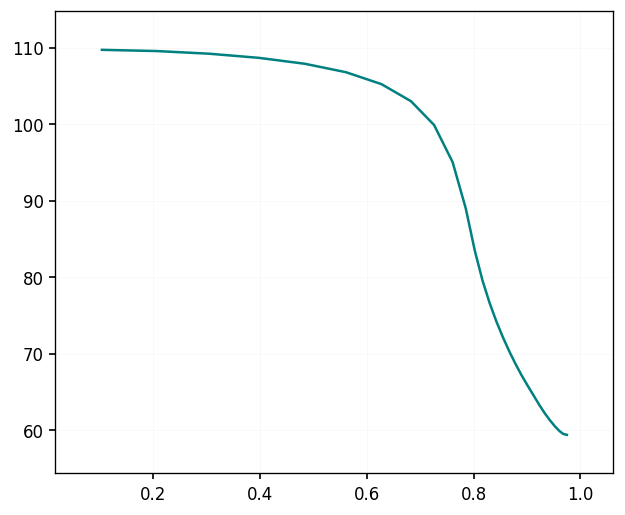

In [22]:
fig, ax = plt.subplots()
Te = fl["Te"]
Ti = fl["Ti"]
Pe = fl["Pe"]
Pi = fl["Pd+"]
Mi = constants("mass_p")*2
tau_e = 1/(fl["Kee_coll"] + fl["Ked+_coll"])
kappa_coefficient_e = 1
kappa_par_e = kappa_coefficient_e * Pe * tau_e / Mi

ax.plot(dist, fl["Td+"])

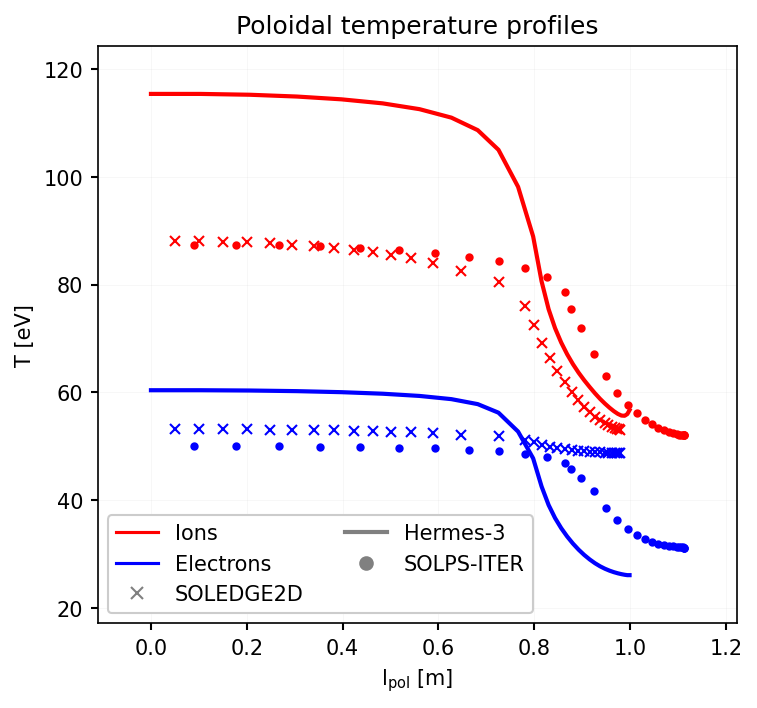

In [32]:
fig, ax = plt.subplots(figsize=(5.5,5),dpi = 150)

sl_data = sl["tightwall_2e19"].regions["outer_fieldline"]
hr_data = hr["afnE_base"].regions["outer_fieldline"]

slstyle = dict(marker = "x", ms = 5, lw = 0)
hrstyle = dict(lw = 2)

ax.plot(sl_data.index, sl_data["Te"], c = "blue", **slstyle)
ax.plot(sl_data.index, sl_data["Td+"], c = "red", **slstyle)
# ax.plot(sl_data.index, sl_data["Ta"], c = "deeppink", **slstyle)

ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, label = "Electrons")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, label = "Ions")

clog = 31 - 0.5 * np.log(sl_data["Ne"]) + np.log(sl_data["Te"])
# data = hr_data["Ne"]**2
# ax2 = ax.twinx()
# ax2.plot(sl_data.index, data, c = "grey", lw = 2, ms = 3)

# ax2 = ax.twinx()
# ax2.plot(hr_data.index, hr_data["Rd+_ex"], c = "deeppink", **hrstyle, label = "Radiation")
# ax2.tick_params(axis = "y", colors = "deeppink") 
# ax.plot(hr_data.index, hr_data["Ta"], c = "deeppink", **hrstyle, label = "Neutrals")
# ax2.set_ylabel("Radiation [Wm-2]", color = "deeppink")

ax.set_xlabel("$l_{pol}$ [m]")
ax.set_ylabel("T [eV]")
ax.set_title("Poloidal temperature profiles")

yind = ysep + 1
param = "te"
data = self.bal[param][:]
hx = self.bal["hx"][:]

x = np.cumsum(hx[yind,slice(omp, None)])
y = data[yind, slice(omp,None)]
ax.plot(x, self.bal["te"][:][yind, slice(omp,None)]/constants("q_e"), marker = "o", lw = 0, c = "b", ms = 3)
ax.plot(x, self.bal["ti"][:][yind, slice(omp,None)]/constants("q_e"), marker = "o", lw = 0, c = "r", ms = 3)
# axes[0].set_title(f"Poloidal plot of {param}")

legend_items = []

legend_items.append(mpl.lines.Line2D([0], [0], color = "red"))
legend_items.append(mpl.lines.Line2D([0], [0], color = "blue"))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 0, marker = "x", ms = 3))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 2, ))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 0, marker = "o", ms = 3))
ax.legend(legend_items, ["Ions", "Electrons", "SOLEDGE2D", "Hermes-3", "SOLPS-ITER"], fontsize = "medium", loc = "lower left", frameon = True, framealpha = 1,ncols = 2)

# With Qei scaling

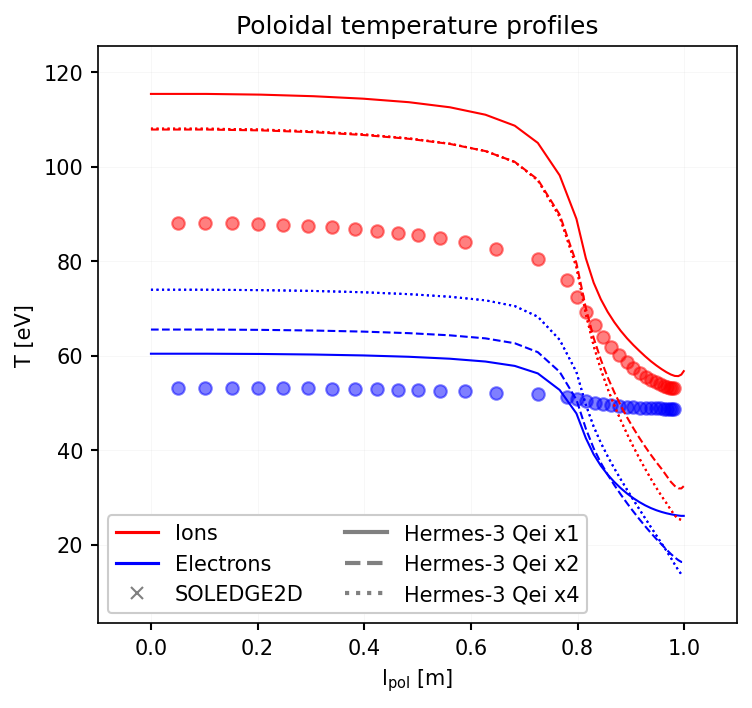

In [36]:
fig, ax = plt.subplots(figsize=(5.5,5),dpi = 150)

sl_data = sl["tightwall_2e19"].regions["outer_fieldline"]


slstyle = dict(marker = "o", ms = 6, alpha = 0.5, lw = 0)
hrstyle = dict(lw = 1)

ax.plot(sl_data.index, sl_data["Te"], c = "blue", **slstyle)
ax.plot(sl_data.index, sl_data["Td+"], c = "red", **slstyle)
# ax.plot(sl_data.index, sl_data["Ta"], c = "deeppink", **slstyle)


hr_data = hr["afnE_base"].regions["outer_fieldline"]
ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, label = "Electrons")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, label = "Ions")

hr_data = hr["afnE_qei_x2"].regions["outer_fieldline"]
ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, ls = "--")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, ls = "--")

hr_data = hr["afnE_qei_x4"].regions["outer_fieldline"]
ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, ls = ":")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, ls = ":")

hr_data = hr["afnE_qei_x4"].regions["outer_fieldline"]
ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, ls = ":")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, ls = ":")

clog = 31 - 0.5 * np.log(sl_data["Ne"]) + np.log(sl_data["Te"])

ax.set_xlabel("$l_{pol}$ [m]")
ax.set_ylabel("T [eV]")
ax.set_title("Poloidal temperature profiles")

yind = ysep + 1
param = "te"
data = self.bal[param][:]
hx = self.bal["hx"][:]

# x = np.cumsum(hx[yind,slice(omp, None)])
# y = data[yind, slice(omp,None)]
# ax.plot(x, self.bal["te"][:][yind, slice(omp,None)]/constants("q_e"), marker = "o", lw = 0, c = "b", ms = 3)
# ax.plot(x, self.bal["ti"][:][yind, slice(omp,None)]/constants("q_e"), marker = "o", lw = 0, c = "r", ms = 3)
# axes[0].set_title(f"Poloidal plot of {param}")

legend_items = []

legend_items.append(mpl.lines.Line2D([0], [0], color = "red"))
legend_items.append(mpl.lines.Line2D([0], [0], color = "blue"))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 0, marker = "x", ms = 3))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 2, ))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 2, ls = "--"))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 2, ls = ":"))
# legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 0, marker = "o", ms = 3))
ax.legend(legend_items, ["Ions", "Electrons", "SOLEDGE2D", "Hermes-3 Qei x1", "Hermes-3 Qei x2", "Hermes-3 Qei x4"], fontsize = "medium", loc = "lower left", frameon = True, framealpha = 1,ncols = 2)

# Model comparison

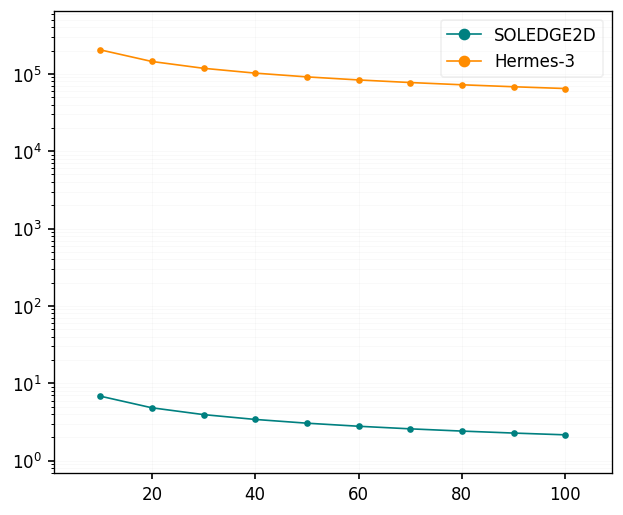

In [8]:
Me = constants("mass_e")
Mi = constants("mass_p") * 2
qe = constants("q_e")
e0 = constants("e0")

Te = 50
Ti = 100
Ne = 1e19
clog = 12
Zi = 1
Ze = 1

def Qei_soledge(Ne, Te, Ti):
    Te *= qe
    Ti *= qe
    tau_e = 3.5e11 * ((Te/qe)**1.5 / (Ne*clog))
    tau_ei = 2 * Mi/Me * tau_e
    Qei = 3/4 * (Ne*Me) / (Mi*tau_ei) * (Te - Ti)

    return abs(Qei)

def Qei_hermes(Ne, Te, Ti):
    Te *= qe
    Ti *= qe
    ve = np.sqrt(2 * Te / Me)
    vi = np.sqrt(2 * Ti / Mi)
    nu_ei = 1/(3*np.pi**1.5 * e0**2) * ((qe*Ze)**2 * (qe*Zi)**2 * Ne * clog) / (ve**2 + vi**2)**1.5 * (1 + Me/Mi) / (Me**2)
    tau_ei = 1/nu_ei
    Qei = 3 * (Ne * Me)/(Mi * tau_ei) * (Te-Ti) 
    
    return abs(Qei)


Ti = np.linspace(10,100,10)
Te = Ti * 0.5

qeis_sl = []
qeis_hr = []

for i in range(len(Ti)):
    qeis_sl.append(Qei_soledge(Ne, Te[i], Ti[i]))
    qeis_hr.append(Qei_hermes(Ne, Te[i], Ti[i]))

fig, ax = plt.subplots()
ax.plot(Ti, qeis_sl, marker = "o", lw = 1, ms = 3, label = "SOLEDGE2D")
ax.plot(Ti, qeis_hr, marker = "o", lw = 1, ms = 3, label = "Hermes-3")
ax.legend()
ax.set_yscale("log")
# Qei_soledge(50,100)

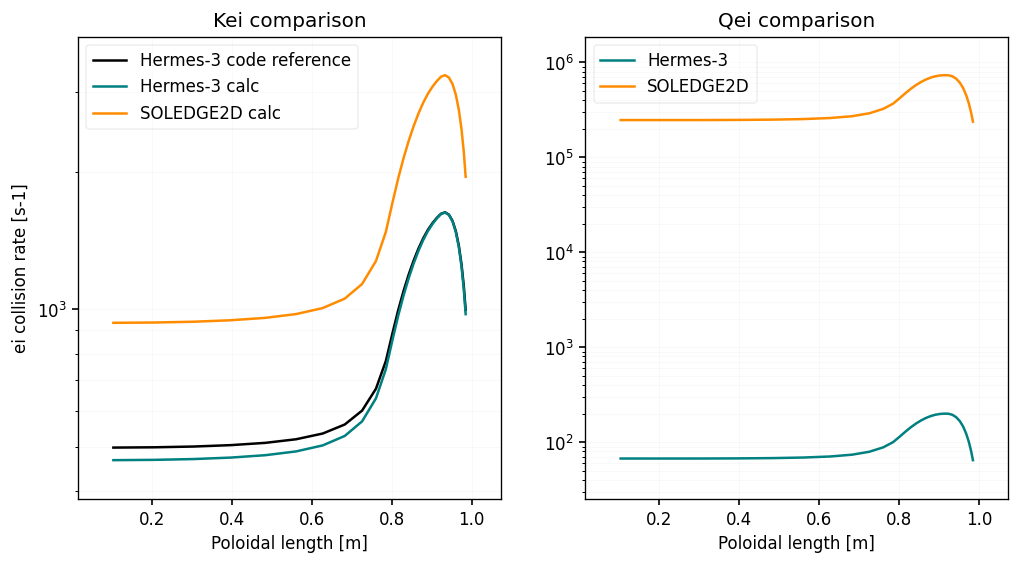

In [21]:
ds = casestore["afnE_mfp1_cond0.25_frec0.48"].ds.isel(t=-1)
m = ds.metadata

fl = ds.hermesm.select_custom_sol_ring(20, "outer_lower")
dist = np.cumsum(fl["dl"]).values.squeeze()
Ne = fl["Ne"].values.squeeze()
Te = fl["Te"].values.squeeze()
Ti = fl["Td+"].values.squeeze()
Kei = (fl["Kd+e_coll"] 
       * fl["Kd+e_coll"].attrs["conversion"]
        # * m["Omega_ci"]
       ).squeeze()

ve = np.sqrt(2 * (qe*Te) / Me)
vi = np.sqrt(2 * (qe*Ti) / Mi)
Kei_calc = 1/(3*np.pi**1.5 * e0**2) \
           * ((qe*Ze)**2 * (qe*Zi)**2 * Ne * clog) \
           / (ve**2 + vi**2)**1.5 \
           * ((1 + Me/Mi) / (Me**2))
           
Kie_calc = ((qe*Ze)**2 * (qe*Zi)**2 * Ne * clog * (1 + Me/Mi)) / ((3*np.pi**1.5 * e0**2) * (ve**2 + vi**2)**1.5 * (Me**2))
Kei_calc = Kie_calc * Me/Mi
tau_ei_calc = 1/Kei_calc
Qei = abs(3 * (Ne * Me)/(Mi * tau_ei_calc) * qe*(Te - Ti) )
           
## SOLEDGE
tau_e = 3.5e11 * ((Te)**1.5 / (Ne*clog))   # Te is in eV
tau_ei = 2 * Mi/Me * tau_e
Kei_calc_sl = 1/tau_ei

tau_ei_sl2 = ((3 * np.sqrt(2) * np.pi**1.5 * e0**2 * Me * Mi) / ( (Ne) * qe**4 * Ze**2 * Zi**2 * clog)) * (qe*Te/Me + qe*Ti/Mi)**1.5 
Kei_calc_sl2 = 1/tau_ei_sl2 
Qei_sl2 = abs(3/2 * Ne / tau_ei_sl2 * qe*(Te - Ti))

# Qei_sl = abs(3/4 * (Ne*Me) / (Mi*tau_ei) * qe*(Te - Ti)    )

fig, axes = plt.subplots(1,2, figsize=(10,5))
ax = axes[0]


ax.plot(dist, Kei, label = "Hermes-3 code reference", c = "k")
ax.plot(dist, Kei_calc, label = "Hermes-3 calc", c = "teal")
ax.plot(dist, Kei_calc_sl2, label = "SOLEDGE2D calc", c = "darkorange")
# ax.plot(dist, Kei_calc_sl2, label = "SOLEDGE2D calc 2")
# ax.set_yscale("log")

ax.set_ylabel("ei collision rate [s-1]")
ax.set_title("Kei comparison")


ax = axes[1]
ax.set_title("Qei comparison")
ax.plot(dist, Qei, label = "Hermes-3")
ax.plot(dist, Qei_sl2, label = "SOLEDGE2D")

for ax in axes:
       ax.legend()
       ax.set_yscale("log")
       ax.set_xlabel("Poloidal length [m]")

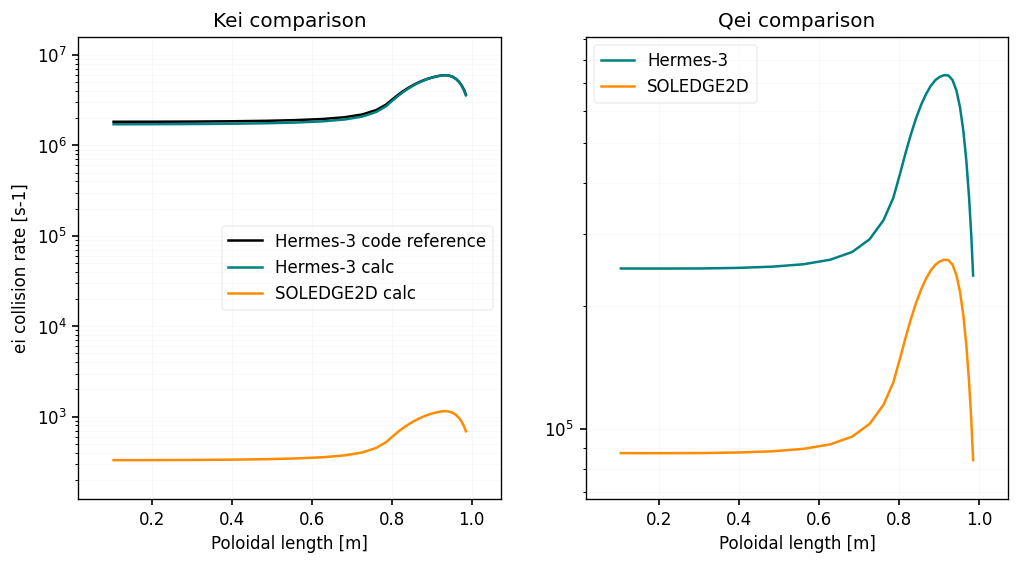

In [37]:
ds = casestore["afnE_mfp1_cond0.25_frec0.48"].ds.isel(t=-1)
m = ds.metadata

fl = ds.hermesm.select_custom_sol_ring(20, "outer_lower")
dist = np.cumsum(fl["dl"]).values.squeeze()
Ne = fl["Ne"].values.squeeze()
Te = fl["Te"].values.squeeze()
Ti = fl["Td+"].values.squeeze()
Kei = (fl["Ked+_coll"] 
       * fl["Ked+_coll"].attrs["conversion"]
        # * m["Omega_ci"]
       ).squeeze()

ve = np.sqrt(2 * (qe*Te) / Me)
vi = np.sqrt(2 * (qe*Ti) / Mi)
A = (np.pi**1.5 * e0**2 * (ve**2 + vi**2)**1.5) / (qe**4 * Ze**2 * Zi**2 * clog)

## Hermes-3
tau_ei_calc = 3/Ne * A * (Me**2 / (1 + Me/Mi))
Kei_calc = 1/tau_ei_calc
Qei_calc = abs( (1/A) * ((Ne*Ne)/(Me*Mi)) * qe*(Te-Ti)  ) 

           
## SOLEDGE
tau_ei_sl = ((3 * np.sqrt(2))/Ne) * A*Me*Mi
Qei_sl = abs( 3/(6*np.sqrt(2)*A) * ((Ne*Ne) /(Me*Mi)) * qe*(Te-Ti) )
Kei_sl = 1/tau_ei_sl

# Qei_sl = abs(3/4 * (Ne*Me) / (Mi*tau_ei) * qe*(Te - Ti)    )

fig, axes = plt.subplots(1,2, figsize=(10,5))
ax = axes[0]


ax.plot(dist, Kei, label = "Hermes-3 code reference", c = "k")
ax.plot(dist, Kei_calc, label = "Hermes-3 calc", c = "teal")
ax.plot(dist, Kei_sl, label = "SOLEDGE2D calc", c = "darkorange")
# ax.plot(dist, Kei_calc_sl2, label = "SOLEDGE2D calc 2")
# ax.set_yscale("log")

ax.set_ylabel("ei collision rate [s-1]")
ax.set_title("Kei comparison")


ax = axes[1]
ax.set_title("Qei comparison")
ax.plot(dist, Qei_calc, label = "Hermes-3")
ax.plot(dist, Qei_sl, label = "SOLEDGE2D")

for ax in axes:
       ax.legend()
       ax.set_yscale("log")
       ax.set_xlabel("Poloidal length [m]")

In [4]:
3/(6*np.sqrt(2))

0.35355339059327373